# Notebook to analyze latent space of UKBioBank, when trained with all subjects of UKBioBank

In [1]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

INFO: you cannot use deep_folding in brainvisa. Probably OK.


/volatile/jc225751/Runs/59_analysis_ukbiobank/Program/2023_agaudin_jchavas_folding_supervised/contrastive/evaluation/train_multiple_classifiers.py:495: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name='config_no_save', config_path="../configs")


In [2]:
# test model
test_model = "/volatile/jc225751/Runs/59_analysis_ukbiobank/Output/trained_on_ukbiobank/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_UkBioBank_full'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)
len(train_df)

21070

In [3]:
dataset_test = 'cingulate_UkBioBank_full'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)


In [4]:
dataset_second = 'cingulate_ACCpatterns'
second_df = pd.read_csv(test_model+'/'+dataset_second+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
second_df.sort_index(inplace=True)


# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_second+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)
len(prediction_df)

341

In [5]:
dataset_third = 'cingulate_HCP_full_gender'
third_df = pd.read_csv(test_model+'/'+dataset_third+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
third_df.sort_index(inplace=True)

In [6]:
prediction_df.head()

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
1-03HUBJO_t0,1,0.792465,0.784215,0.793623,0.784570,0.819344,0.822166,0.762999,0.777797,0.769743,...,0.725859,0.825874,0.731402,0.780195,0.793195,0.763955,0.813311,0.771330,0.770732,0.753232
1-08ANDTI_t0,1,0.246454,0.264815,0.252589,0.261357,0.255166,0.251240,0.288211,0.255614,0.272151,...,0.296794,0.263412,0.282334,0.253301,0.279997,0.270343,0.238273,0.266013,0.265820,0.282183
1-11LEBJO_t0,1,0.194381,0.212955,0.200071,0.209572,0.199256,0.195186,0.238535,0.204846,0.221854,...,0.251633,0.206160,0.236422,0.202345,0.226571,0.220773,0.184198,0.215011,0.215689,0.233731
1-15LEHMI_t0,0,0.745649,0.739201,0.747505,0.739192,0.774505,0.777090,0.720365,0.731689,0.725382,...,0.684882,0.782183,0.688638,0.733865,0.749907,0.719392,0.766432,0.725746,0.726112,0.710038
1-17COLMA_t0,0,0.179228,0.197646,0.184734,0.194319,0.183047,0.178996,0.223580,0.189915,0.206877,...,0.237851,0.189511,0.222534,0.187392,0.210699,0.206004,0.168667,0.200021,0.200857,0.219155


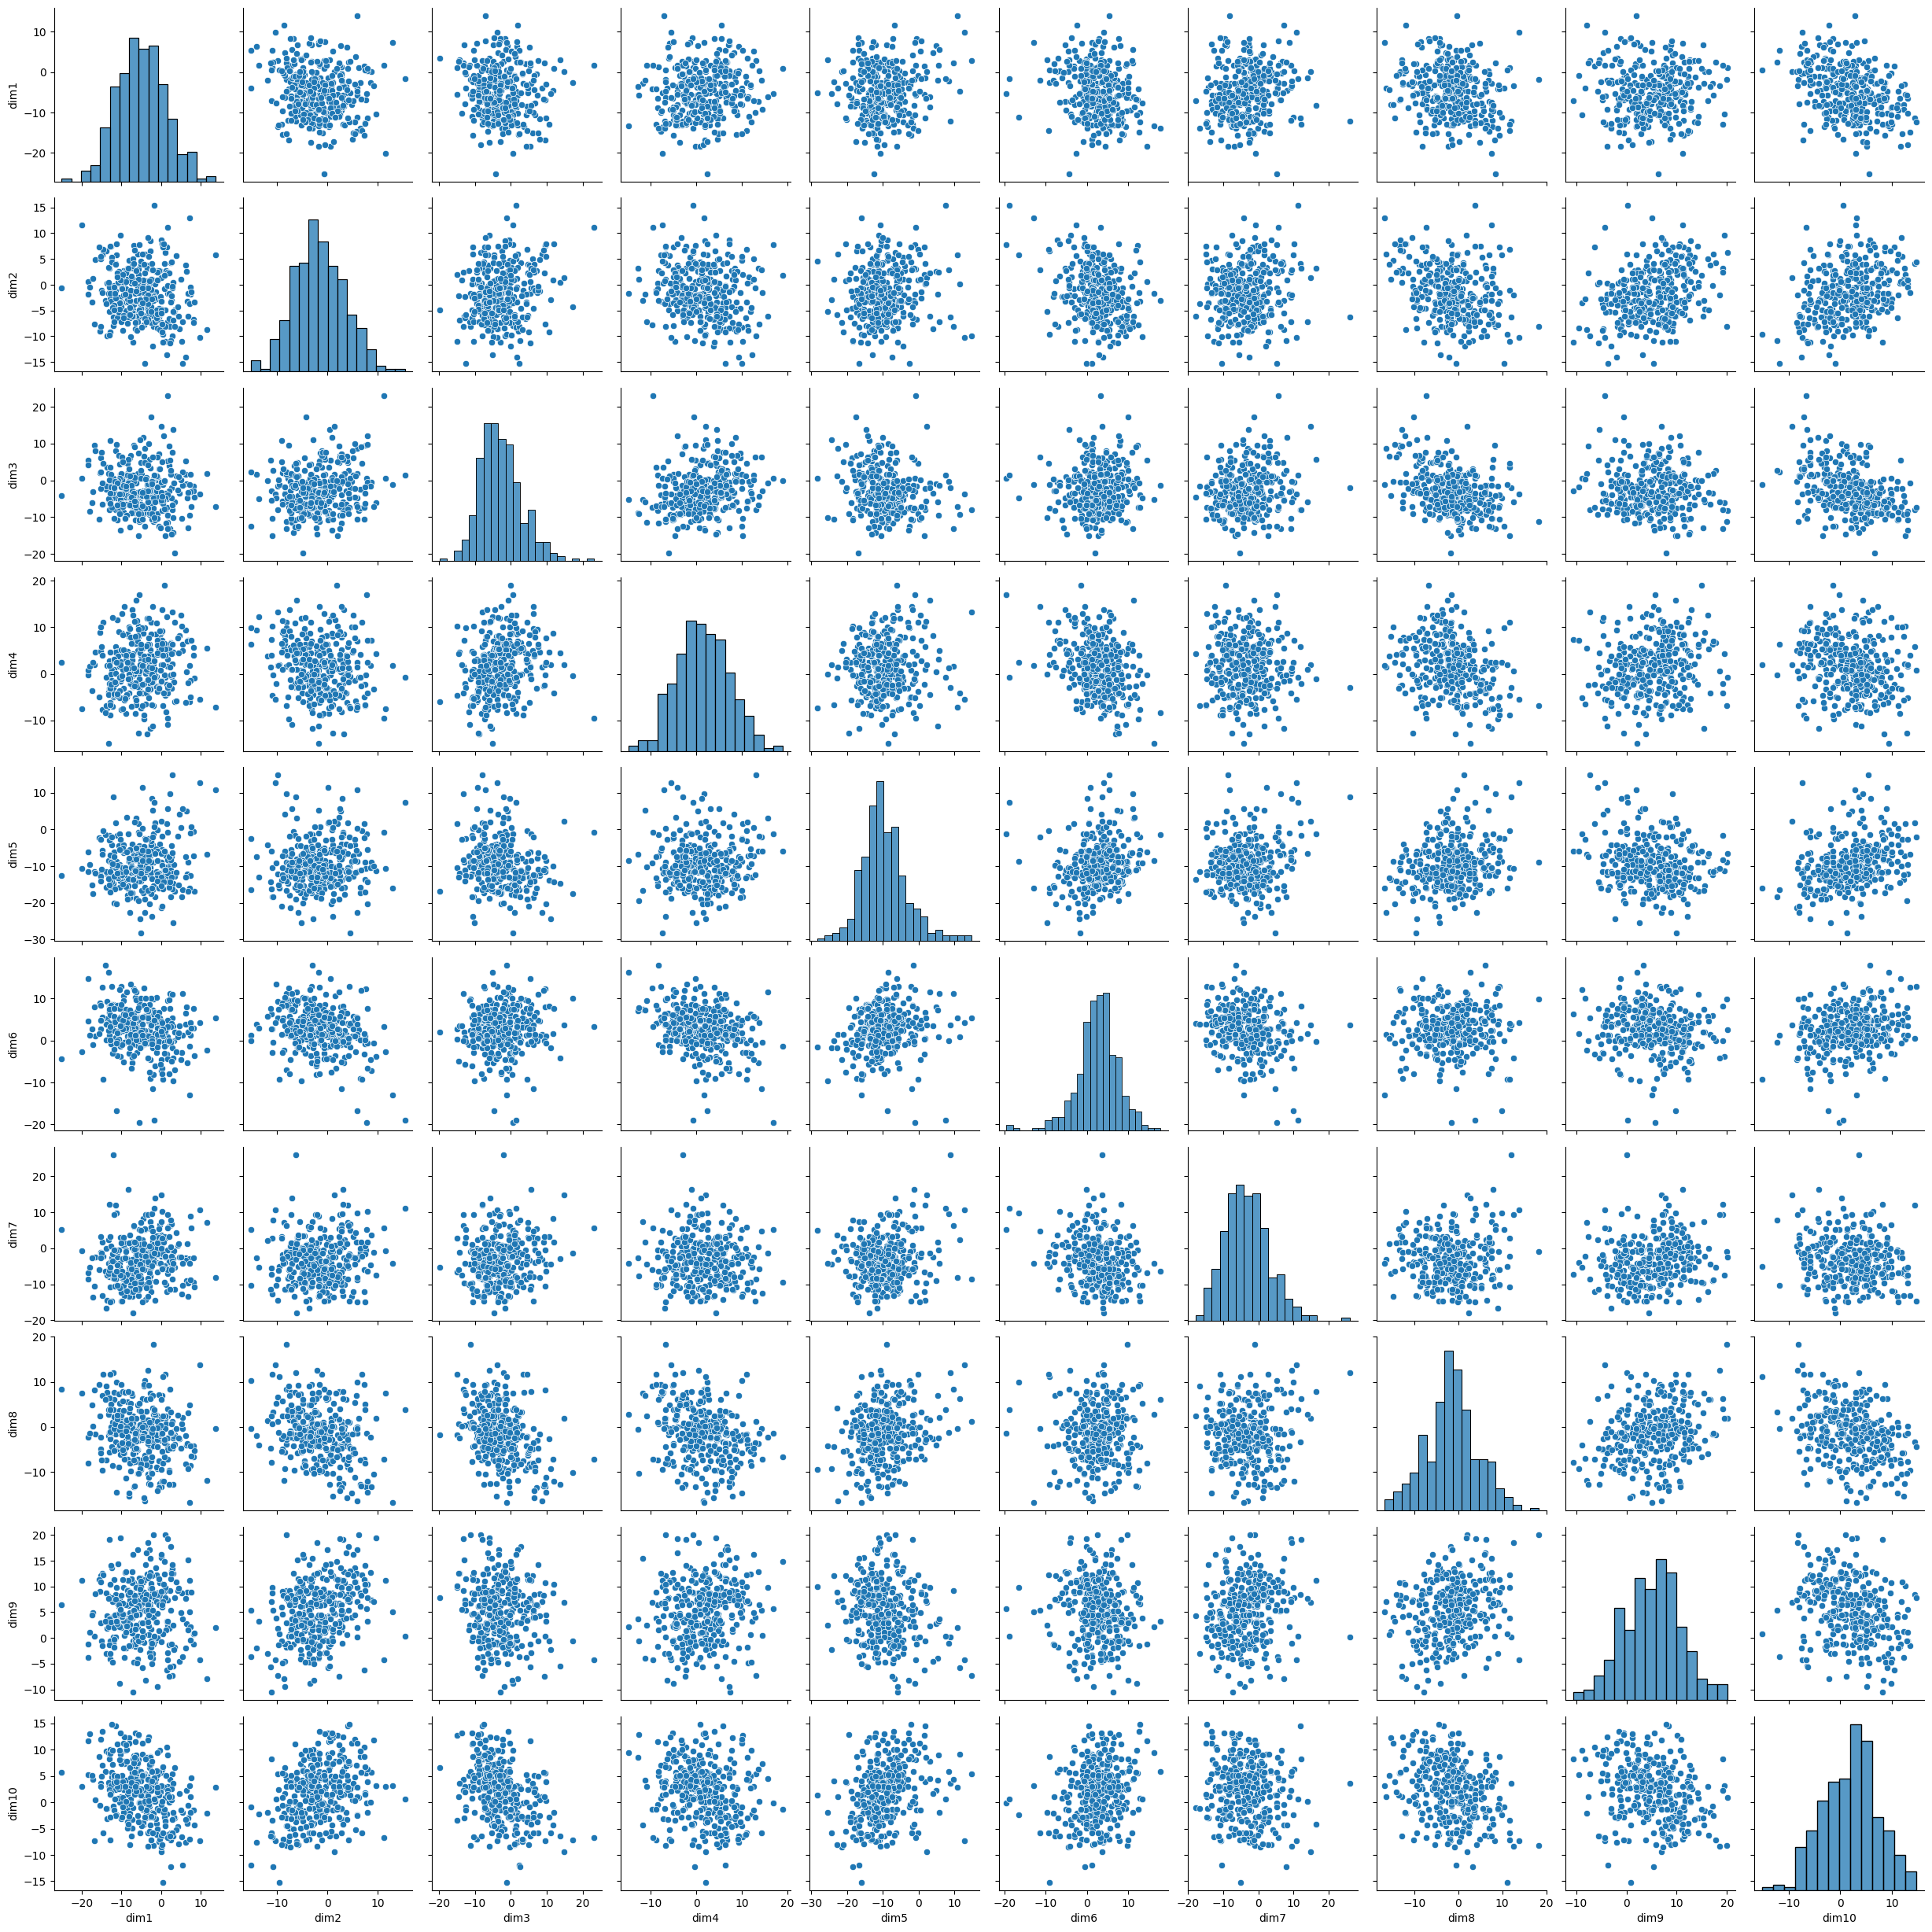

In [7]:
sns.pairplot(second_df)

## Visualize umap

In [8]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    # plt.figure()
    # plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.4)

    # plot for true labels/volatile/jc225751/Runs/59_analysis_ukbiobank/Output/
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c=colors, s=1, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [9]:
def compute_umap(df, n_neighbors=15):
    # apply umap
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [10]:
len(third_df)

1113

# UMAP on UKBioBank

In [11]:
visual_embs, reducer = compute_umap(test_df, n_neighbors=100)

In [12]:
ukbiobank_embs = visual_embs.copy()

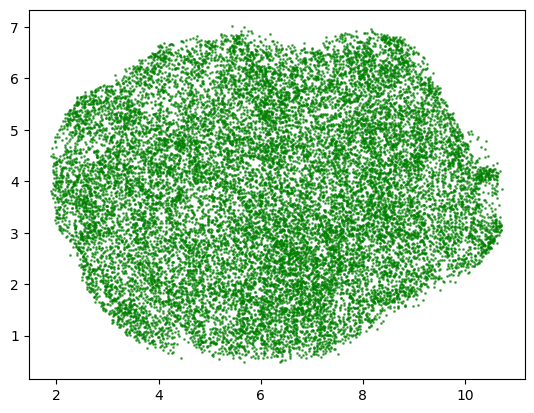

In [13]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)

In [14]:
second_embs = reducer.transform(second_df)

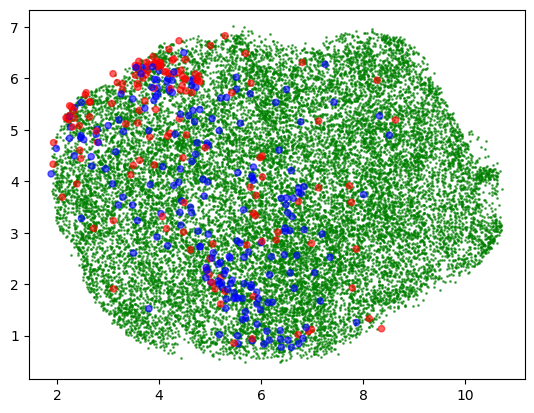

In [15]:
# plot for true labels
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]

plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)
plt.scatter(second_embs[:,0], second_embs[:,1], c=colors, s=20, alpha=0.6)

In [16]:
third_embs = reducer.transform(third_df)

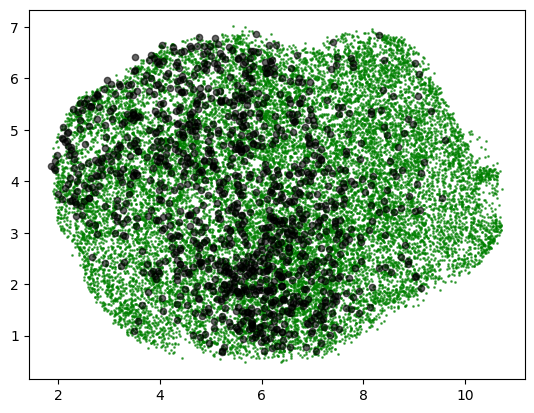

In [17]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)
plt.scatter(third_embs[:,0], third_embs[:,1], c='black', s=20, alpha=0.6)

# UMAP on ACCpatterns

In [33]:
visual_embs, reducer = compute_umap(second_df, n_neighbors=15)

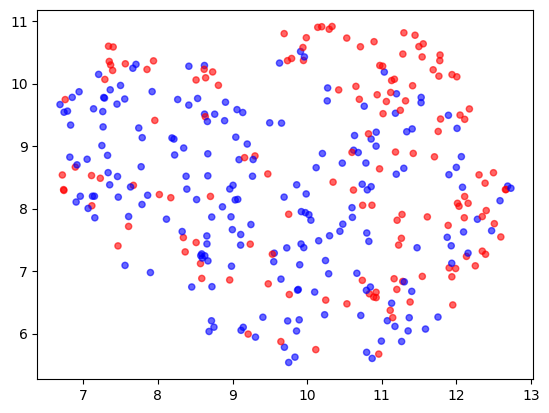

In [35]:
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]
plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, s=20, alpha=0.6)

In [36]:
test_embs = reducer.transform(test_df)

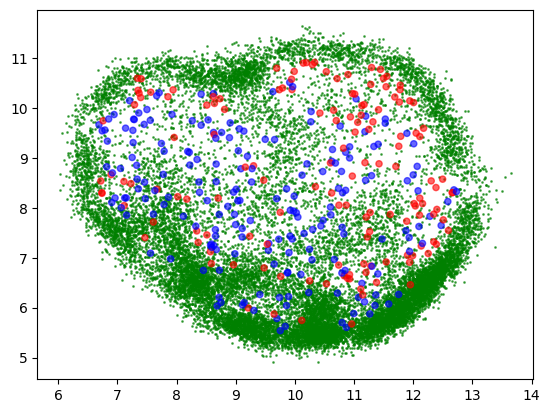

In [38]:
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]
plt.scatter(test_embs[:,0], test_embs[:,1], c='g', s=1, alpha=0.6)
plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, s=20, alpha=0.6)

# UMAP on HCP

In [18]:
visual_embs, reducer = compute_umap(third_df, n_neighbors=15)

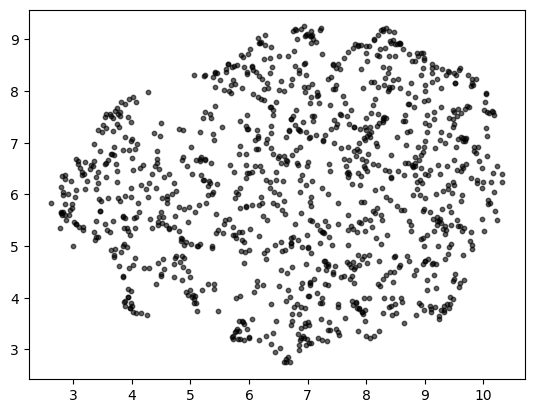

In [19]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=10, alpha=0.6)

In [20]:
second_embs = reducer.transform(second_df)

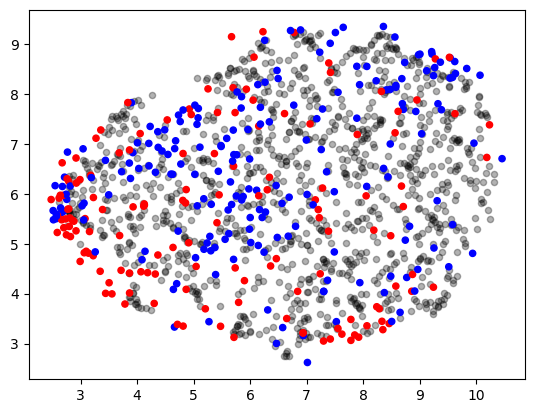

In [21]:
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]

plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=20, alpha=0.3)
plt.scatter(second_embs[:,0], second_embs[:,1], c=colors, s=20, alpha=1)

In [22]:
second_df.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
1-03HUBJO_t0,-5.754253,3.078586,-7.888584,0.087529,-0.789996,5.483637,-13.182101,-0.121508,5.131477,8.060051
1-08ANDTI_t0,1.088328,-11.042294,-14.992330,-4.669141,-10.526248,2.802538,2.753804,11.640773,9.842704,-3.447931
1-11LEBJO_t0,-1.836876,-8.145627,-11.142085,-6.752227,-8.926461,9.820431,-1.027278,18.260162,20.029728,-8.143515
1-15LEHMI_t0,-11.456051,4.063096,-7.979030,5.857479,1.790742,0.411421,12.011239,-3.431442,8.380008,14.502483
1-17COLMA_t0,-0.297105,2.693733,-4.022460,7.794108,-3.994520,4.481436,6.465611,-12.552568,10.662281,9.809521


In [23]:
third_embs = reducer.transform(test_df)

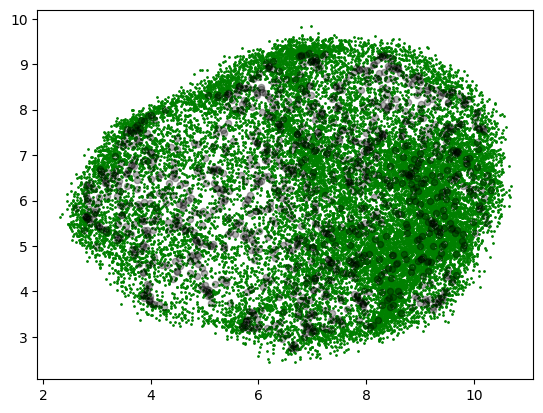

In [24]:
plt.scatter(third_embs[:,0], third_embs[:,1], c='green', s=1, alpha=1)
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=20, alpha=0.3)

# Density map of UKBioBank

In [25]:
Z, xedges, yedges = np.histogram2d(ukbiobank_embs[:,0], ukbiobank_embs[:,1], bins=50, normed=True)

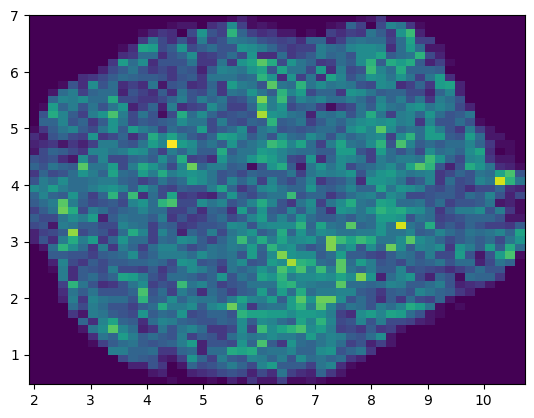

In [26]:
plt.pcolormesh(xedges, yedges, Z.T)

In [27]:
# fig, ax = plt.subplots(figsize=[15,8])
# plt.imshow(Z.T)

In [28]:
Z = Z/np.unique(Z)[1]

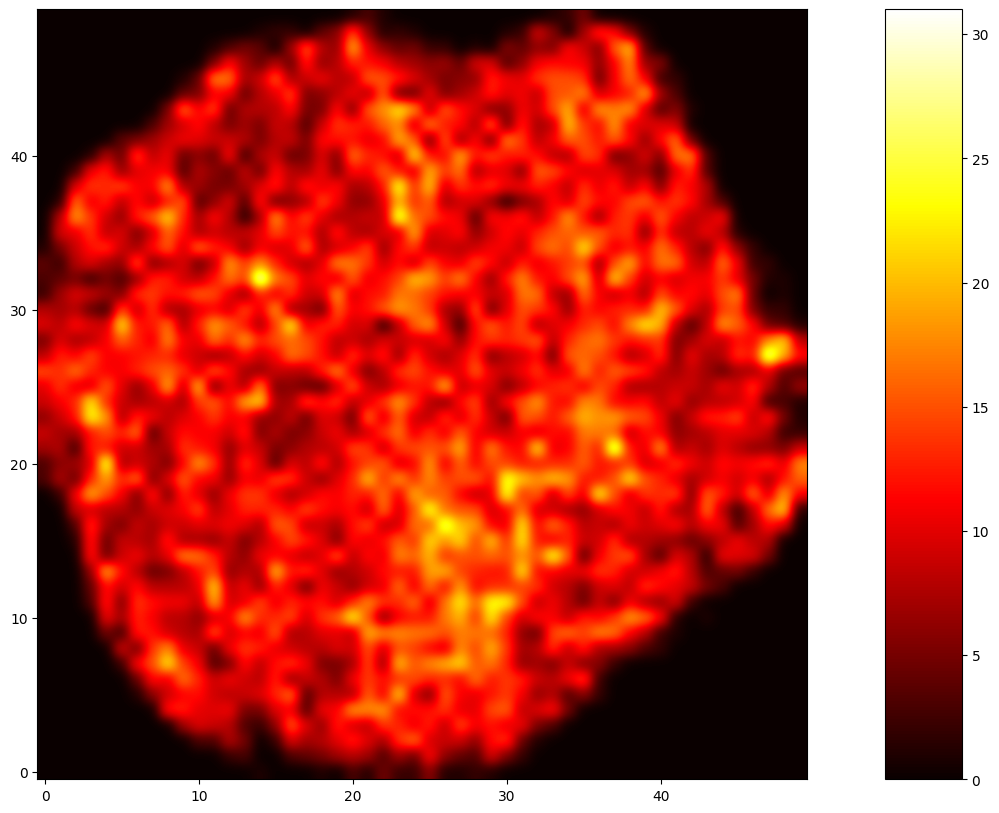

In [29]:
fig, ax = plt.subplots(figsize=[20,10])
cax = ax.imshow(Z.T,
          origin='lower',
          cmap='hot', 
          interpolation='gaussian'
          )
cbar   = fig.colorbar(cax,aspect=10)

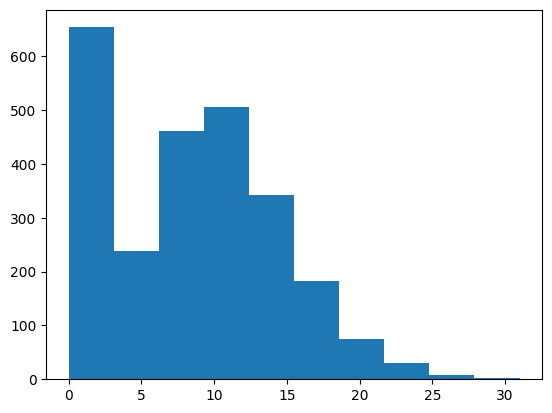

In [30]:
h = plt.hist(Z.reshape(Z.size,1), bins=10)

In [31]:
# import scipy.ndimage as ndi

In [32]:
# img = ndi.gaussian_filter(Z, (1,1))
# f, axs = plt.subplots(1, 1, figsize=(15, 15))
# plt.imshow(img)